* 入力は300x300x3を中心部144x144x3切り出し（概ね0.5倍、150x150だとpooling2段目以降で端数が出るため)
* VAEのエンコーダ部分、基本的に3x3コンボリューション＋2x2MaxPoolの繰り返し＋1x1Convのチャンネル削減
* 潜在変数の数はlatent_dimで指定

In [1]:
import keras
from keras import Input, layers
from keras.models import Sequential,Model
from keras import backend as K
import numpy as np

img_shape = (144,144,3)
batch_size = 128
latent_dim = 16

input_img = keras.Input(shape=img_shape)
x = layers.Dropout(0.5)(input_img)
x = layers.SeparableConv2D(32, 3, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.MaxPooling2D()(x)
x = layers.SeparableConv2D(64, 3, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.Conv2D(32, 1, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.MaxPooling2D()(x)
x = layers.SeparableConv2D(64, 3, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.Conv2D(32, 1, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.MaxPooling2D()(x)
x = layers.SeparableConv2D(96, 3, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.Conv2D(48, 1, padding="same", activation="elu", kernel_initializer="he_normal")(x)

shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="elu", kernel_initializer="he_normal")(x)

z_mean = layers.Dense(latent_dim, kernel_initializer="he_normal")(x)
z_log_var = layers.Dense(latent_dim, kernel_initializer="he_normal")(x)

encoder = Model(input_img, z_mean)

Using TensorFlow backend.


* デコード部分(訓練時のみ使用)
* こちらも基本デコンボリューションによるアップスケールの繰り返し

In [2]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + epsilon * K.exp(z_log_var)

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [3]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation="elu", kernel_initializer="he_normal")(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(64, 3, padding="same", activation="elu", strides=(2,2), kernel_initializer="he_normal")(x)
x = layers.Conv2DTranspose(64, 3, padding="same", activation="elu", strides=(2,2), kernel_initializer="he_normal")(x)
x = layers.Conv2DTranspose(32, 3, padding="same", activation="elu", strides=(2,2), kernel_initializer="he_normal")(x)
x = layers.SeparableConv2D(32, 3, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.Conv2D(32, 1, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.Conv2D(3, 1, padding="same", activation="sigmoid", kernel_initializer="he_normal")(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [4]:
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = K.sigmoid(inputs[0])
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

* モデル構築して内容確認

In [5]:
from keras.preprocessing import image
import glob
import matplotlib.pyplot as plt
from keras import optimizers
%matplotlib inline

vae = Model(input_img, y)
vae.compile(optimizer="adam", loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 144, 144, 3)  0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 144, 144, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 144, 144, 32) 155         dropout_1[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 72, 72, 32)   0           separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
separable_

* 画像入力のための変換はkerasのImageDataGeneratorを使用
* zoom_rangeを約0.5にして口元を拡大（全体を入れると潜在変数が口元以外にも使われてしまうので）
* 0.48倍は300→144の倍率、スケーリングが入らないことを意図。といいながら心配なのでinterpolationも設定しておく

In [6]:
#Enable below 2 lines for learning contiueasly
#logdir = "./keras_log/run-20180831232956/"
#vae.load_weights(logdir + "/SSSD_challenge_weights.h5")
traindata_path = "D:/MLData/kyushu_k_SSSD/training/"
testdata_path = "D:/MLData/kyushu_k_SSSD/test/"
my_zoom_range = [0.48,0.48]

In [7]:
files = glob.glob(traindata_path + "/*/*/*.jpg")
TOTAL_DATANUM = len(files)
train_datagen = image.ImageDataGenerator(
    rescale=1./255.,
    zoom_range=my_zoom_range,
    samplewise_std_normalization = True,
    samplewise_center = True
)
train_generator = train_datagen.flow_from_directory(
    traindata_path,
    target_size=(img_shape[0],img_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    interpolation='lanczos'
)

Found 1317836 images belonging to 39 classes.


* 効率よくデータを突っ込むためImageDataGeneratorの実行は別スレッドにする

In [8]:
import threading
import queue

class QueuePutter:
    def __init__(self, queue, generator):
        self.queue = queue
        self.generator = generator
        
    def start(self, numworker):
        self.running = True
        self.threads = [threading.Thread(target=self.run) for _ in range(numworker)]
        for t in self.threads:
            t.start()
            
    def stop(self):
        self.running = False
        while not self.queue.empty():
            self.queue.get()
        for t in self.threads:
            t.join()
            
    def run(self):
        while self.running:
            batch = self.generator.next()
            self.queue.put(batch)

* 訓練は全サンプル..としたいがとても時間が掛かるので適当に切り上げ
* 訓練数による潜在変数精度への影響は定量調査できてない、下の画像の出来具合で判断

In [9]:
img_queue = queue.Queue(2)
qp = QueuePutter(img_queue, train_generator)
qp.start(2)

for i in range(4000):#(TOTAL_DATANUM+batch_size-1)//batch_size):
    batch = img_queue.get()
    vae.fit(
        x=batch[0],y=None,
        steps_per_epoch=16,
        initial_epoch=i,
        epochs=(i+1),
        verbose=0
    )

qp.stop()

* 適当な2次元を振って、潜在変数→デコードが正しくできるか目視確認
* lossは入力画像vsデコード画像なので、デコード後の出来が良ければ間接的にエンコーダの出来も良いと言える(?)

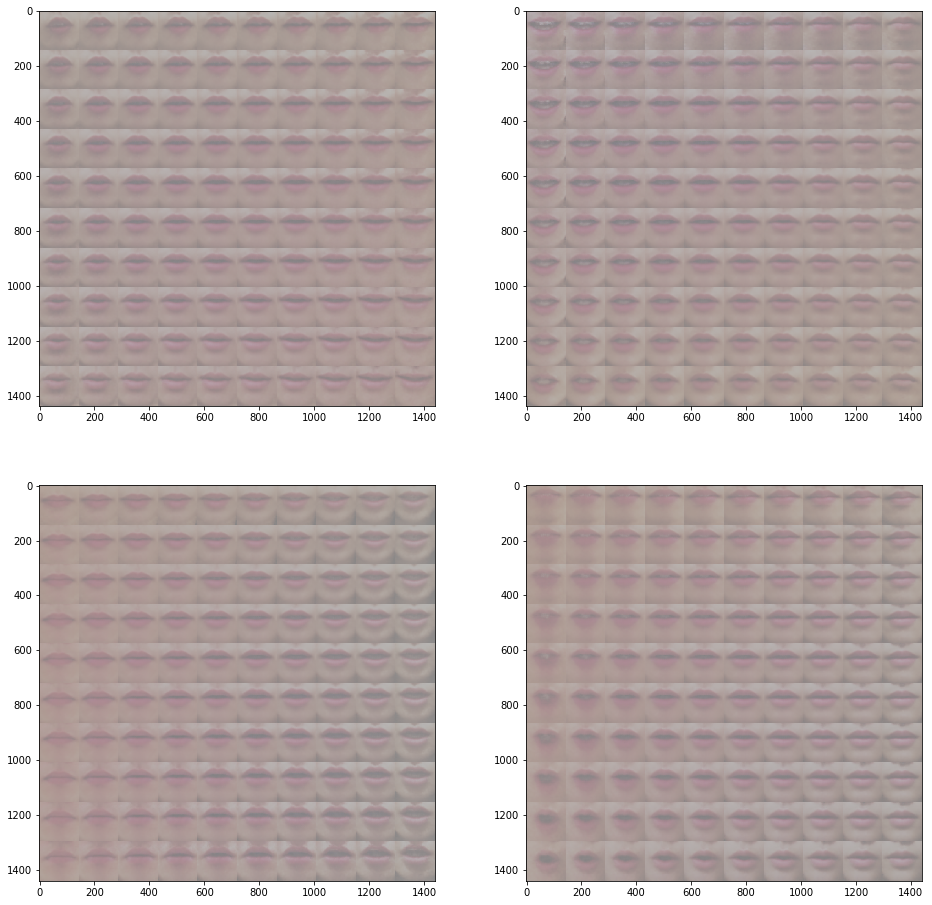

In [10]:
from scipy.stats import norm

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def create_img_matrix(img_shape,axis_pair):
    n = 10
    if img_shape.ndim == 2:
        h,w = img_shape
        c = 1
    else:
        h,w,c = img_shape
        
    figure = np.empty((h*n,w*n,c))
    grid_x = norm.ppf(np.linspace(0.05,.95,n))
    grid_y = norm.ppf(np.linspace(0.05,.95,n))
    grid_other = norm.ppf(0.5)
    for i,yi in enumerate(grid_y):
        for j,xi in enumerate(grid_x):
            z_sample = np.array([[grid_other]*latent_dim])
            z_sample[0][axis_pair[0]] = xi
            z_sample[0][axis_pair[1]] = yi
            z_sample = np.tile(z_sample,batch_size).reshape(batch_size, latent_dim)
            x_decoded = decoder.predict(z_sample, batch_size=batch_size)
            img_decoded = x_decoded[0].reshape((h,w,c))
            figure[i*h:(i+1)*h, j*w:(j+1)*w,:] = img_decoded
    return figure

img_mats = [create_img_matrix(np.array(img_shape),ax_pair) for ax_pair in ((0,1),(2,3),(4,5),(6,7))]
fix, ax = plt.subplots(nrows=2,ncols=2,figsize=(16,16))
for i in range(4):
    ax[i//2,i%2].imshow(sigmoid(img_mats[i]))
plt.show()

* 後で復帰できるようモデル/重みデータを保存

In [11]:
from datetime import datetime
import os

logdir = "./keras_log/run-{}/".format(datetime.utcnow().strftime("%Y%m%d%H%M%S"))
if not os.path.exists(logdir):
    os.makedirs(logdir)

json_string = vae.to_json()
with open(logdir + 'SSSD_challenge_model.json','w') as w:
    w.write(json_string)

vae.save_weights(logdir + 'SSSD_challenge_weights.h5')

* エンコーダ部分のみを使い、画像データ群を時系列潜在変数の配列に変換
* (750,個人毎の時系列データ最大長(最大121),latent_dim)の"data"、(750,)の"label"を個人毎にsxx.npzとして保存
* ImageDataGeneratorの引数は訓練時が同じになっているか確認の事

In [14]:
import tensorflow as tf

graph = tf.get_default_graph()

def get_encoded_df(root_path):
    files = glob.glob(root_path + "/*/*.jpg")
    numframes = len(files)
    batch_size = 32
    datagen = image.ImageDataGenerator(
        rescale=1./255.,
        zoom_range=my_zoom_range,
        samplewise_std_normalization = True,
        samplewise_center = True
    )
    encode_generator = datagen.flow_from_directory(
        root_path,
        target_size=(img_shape[0],img_shape[1]),
        class_mode='binary',
        batch_size=batch_size,
        shuffle=False,
        interpolation='lanczos'
    )
    result = []
    for i in range((numframes+batch_size-1)//batch_size):
        with graph.as_default():
            batch = encode_generator.next()
            z_sample = encoder.predict(x=batch[0])
        classes=batch[1]
        result.append({"z":z_sample, "class":classes})
    classes = np.hstack([result[i]["class"] for i in range(len(result))])
    z_sample = np.vstack([result[i]["z"] for i in range(len(result))])
    
    return classes, z_sample

def create_result(from_path, to_path):
    cls,z_sample = get_encoded_df(from_path)
    unique,counts = np.unique(cls,return_counts=True)
    maxlen = np.max(counts)
    arrays = []
    for i in range(np.max(cls).astype(int) + 1):
        data = z_sample[cls==i]
        nans = np.empty((maxlen,z_sample.shape[1]),dtype=np.float)
        nans[:,:] = np.nan
        nans[:len(data),:] = data
        arrays.append(nans)
        
    data = np.stack(arrays)
    label = np.arange(25).repeat(30).T.flatten()
    person_str = from_path.replace("\\","/")
    person_str = person_str[person_str.rfind("/")+1:]
    np.savez(to_path + person_str + ".npz",data=data,label=label)

* Step2でのRNN訓練用に訓練画像を全て潜在変数配列に変換
* ストレージ速度/CPU速度に依存、手元環境では約1時間。CPU/HDD負荷を見ながらもう少しスレッド数増やしても良いかも

In [15]:
import threading
def createResultWorker(sem,from_path,to_path):
    with sem:
        create_result(from_path, to_path)


person_dir_list = glob.glob(traindata_path + "/s[0-3][0-9]")

sem = threading.Semaphore(6)
my_threads = [threading.Thread(target=createResultWorker,args=(sem,fromdir,logdir)) for fromdir in person_dir_list]
for my_thread in my_threads:
    my_thread.start()
    
for my_thread in my_threads:
    my_thread.join()

Found 30631 images belonging to 750 classes.
Found 37206 images belonging to 750 classes.
Found 37560 images belonging to 750 classes.
Found 34573 images belonging to 750 classes.
Found 36228 images belonging to 750 classes.
Found 33769 images belonging to 750 classes.
Found 34996 images belonging to 750 classes.
Found 41020 images belonging to 750 classes.
Found 42172 images belonging to 750 classes.
Found 37259 images belonging to 750 classes.
Found 34690 images belonging to 750 classes.
Found 38823 images belonging to 750 classes.
Found 42513 images belonging to 750 classes.
Found 39310 images belonging to 750 classes.
Found 34172 images belonging to 750 classes.
Found 32940 images belonging to 750 classes.
Found 39206 images belonging to 750 classes.
Found 36842 images belonging to 750 classes.
Found 43402 images belonging to 750 classes.
Found 33838 images belonging to 750 classes.
Found 34996 images belonging to 750 classes.
Found 42172 images belonging to 750 classes.
Found 3882

* テスト用データも同様に変換
* ただし訓練データと異なり、ラベル情報は添付しない

In [16]:
testdir_list = glob.glob(testdata_path + "*000")

def create_test(from_path, to_path):
    cls,z_sample = get_encoded_df(from_path)
    unique,counts = np.unique(cls,return_counts=True)
    maxlen = np.max(counts)
    arrays = []
    for i in range(np.max(cls).astype(int) + 1):
        data = z_sample[cls==i]
        nans = np.empty((maxlen,z_sample.shape[1]),dtype=np.float)
        nans[:,:] = np.nan
        nans[:len(data),:] = data
        arrays.append(nans)
        
    data = np.stack(arrays)
    np.savez(to_path + "test.npz",data=data)
    
def createTestWorker(sem,from_path,to_path):
    with sem:
        create_test(from_path, to_path)

sem = threading.Semaphore(5)
my_threads = [threading.Thread(target=createResultWorker,args=(sem,fromdir,logdir)) for fromdir in testdir_list]
for my_thread in my_threads:
    my_thread.start()
    
for my_thread in my_threads:
    my_thread.join()

Found 47458 images belonging to 1000 classes.
Found 48071 images belonging to 1000 classes.
Found 47684 images belonging to 1000 classes.
Found 47655 images belonging to 1000 classes.
Found 48046 images belonging to 1000 classes.
